Copyright © 2020, Weta Digital, Ltd.

SPDX-License-Identifier: Apache-2.0

# Spectral Camera Model
This notebook shows an example of using measured camera spectral sensitivity data to construct a virtual camera response model.


### Utility functions

In [ ]:
# Camera RGB to XYZ matrices are extracted from dcraw by Dave Coffin
# https://www.dechifro.org/dcraw/

# Camera spectral sensitivity and training data is taken from the rawtoaces repo:
# https://github.com/ampas/rawtoaces

!pip install -q colour-science
!pip install -q matplotlib

import colour
import numpy as np
import math

from colour import SpectralDistribution, SpectralShape, MultiSpectralDistributions, sd_to_XYZ

# Grab the given camera data json from the rawtoaces repo and return the 
# sensitivity curves
def load_ampas_camera_data(camera_json):
  import requests
  import json

  url = 'https://raw.githubusercontent.com/ampas/rawtoaces/master/data/camera/%s' % camera_json
  json = json.loads(requests.get(url).text)


  return json['spectral_data']['data']['main']


# Grab the 190-swatch data set from rawtoaces repo and convert it to an array
# of SpectralDistributions
def load_ampas_training_data():
  import requests
  import json
  
  training_data_url = 'https://raw.githubusercontent.com/ampas/rawtoaces/master/data/training/training_spectral.json'
  training_data_dict = json.loads(requests.get(training_data_url).text)['spectral_data']['data']['main']
  
  patches = []
  first = True
  for l, values in training_data_dict.items():
    for i, v in enumerate(values):
      if first:
        patches.append({})
      patches[i][int(l)] = v
    first = False
  
  patches_sd = []
  for p in patches:
    patches_sd.append(colour.SpectralDistribution(p))

  return patches_sd


# Returns a tuple of (SpectralDistribution, xy) of the calculated colour
# for the given temperature. Temperature must be <= 25000.
# The returned spectral distribution is normalized such that Y=1
def calculate_whitepoint(temperature=6500.0):
  # CIE 015:2004 scale temperature so e.g. 6500 becomes 6504
  temperature = float(temperature) * 1.4388 / 1.4380

  # D is only defined over the domain [4000, 25000] so we use blackbody 
  # outside that domain
  if temperature < 4000:
    sd = colour.sd_blackbody(temperature)
  else:
    xy = colour.temperature.CCT_to_xy_CIE_D(temperature)
    sd = colour.sd_CIE_illuminant_D_series(xy)

  # Normalize such that Y=1
  xyz = sd_to_XYZ(colour.sd_ones(), illuminant=sd)
  # Calculate matching chromaticity coordinates
  xy = colour.XYZ_to_xy(xyz)
  return (sd / xyz[1], xy)


# Calculate example whites we'll use below
sd_d65, xy_d65 = calculate_whitepoint(6500.0)
sd_3200, xy_3200 = calculate_whitepoint(3200.0)



In [ ]:
# Convert the BabelColor Average chart to XYZ via Camera RGB
def create_chart(cmf, src_illuminant_sd, dst_illuminant_sd, rgb_to_xyz, rgb_white):
  checkersd = colour.COLOURCHECKERS_SDS['BabelColor Average']
  chart_data = []
  for name, sd in checkersd.items():
    xyz_cam = sd_to_CameraRGB_to_XYZ(sd, cmf, src_illuminant_sd, rgb_to_xyz, rgb_white)
    chart_data.append(colour.XYZ_to_sRGB(xyz_cam))

  return chart_data


# Draw macbeth chart for comparison
def draw_chart(swatches, labels=None, figsize=20):
  import numpy as np
  import matplotlib.pyplot as plt
  from matplotlib.patches import Rectangle
  from matplotlib.collections import PatchCollection

  swatches = np.array(swatches)

  if len(swatches.shape) != 3:
    raise TypeError('swatches must be a list of lists of colors, i.e. shape is (N, 24, 3)')

  if swatches.shape[0] > 5:
    raise ValueError('only 5 sets supported')

  num_sets = swatches.shape[0]

  fig, ax = plt.subplots(figsize=(figsize, figsize))
  ax.set_aspect(1)
  ax.set_ylim((0.0, 0.8))
  patches = [[] for s in range(num_sets)]
  num_cols = 6
  num_rows = 4
  gap = 0.03
  offset = 0.04
  base_size = 4
  size = (1 - offset * 2 - (gap * (num_cols-1))) / num_cols
  for row in range(0, num_rows):
    for col in range(0, num_cols):
      y = (num_rows - row - 1) * (size + gap) + offset * base_size
      x = col * (size + gap) + offset

      if num_sets == 1:
        patches[0].append(Rectangle((x, y), size, size))
      elif num_sets == 2:
        # draw the second patch as the background, then the first as the inset
        patches[0].append(Rectangle((x, y), size, size))
        s = size/2
        patches[1].append(Rectangle((x+s/2, y+s/2), s, s))
        pass
      elif num_sets == 3:
        # draw the first two sets as left and right halves of the bg, then the
        # last as the inset
        s = size/2
        patches[0].append(Rectangle((x, y), s, size))
        patches[1].append(Rectangle((x+s, y), s, size))
        patches[2].append(Rectangle((x+s/2, y+s/2), s, s))
      elif num_sets == 4:
        # Same but split the right half into quarters
        s = size/2
        patches[0].append(Rectangle((x, y), s, size))
        patches[1].append(Rectangle((x+s, y), s, s))
        patches[2].append(Rectangle((x+s, y+s), s, s))
        patches[3].append(Rectangle((x+s/2, y+s/2), s, s))
      elif num_sets == 5:
        s = size/2
        patches[0].append(Rectangle((x, y), s, s))
        patches[1].append(Rectangle((x, y+s), s, s))
        patches[2].append(Rectangle((x+s, y), s, s))
        patches[3].append(Rectangle((x+s, y+s), s, s))
        patches[4].append(Rectangle((x+s/2, y+s/2), s, s))

  patches = [p for s in patches for p in s]

  patches.insert(0, Rectangle((0, 0), 1, size*num_rows + offset * (base_size+1) + gap * (num_rows-1)))

  coll = PatchCollection(patches)
  colors = swatches.reshape(-1, swatches.shape[-1])
  colors = np.insert(colors, 0, [0.1, 0.1, 0.1], 0)
  colors = np.clip(colors, 0.0, 1.0)
  coll.set_color(colors)
  ax.add_collection(coll)

  if labels is not None:
    textsize = figsize
    c2 = 0.2
    if num_sets == 1:
      plt.text(offset, offset * 5.0/2 * 1.2, labels[0], color='white', size=textsize)
    elif num_sets == 2:
      plt.text(offset, offset * 5.0/2 * 1.2, 'Background:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 5.0/2 * 1.2, labels[0], color='white', size=textsize)
      plt.text(offset, offset * 4.0/2 * 1.2, 'Inset:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 4.0/2 * 1.2, labels[1], color='white', size=textsize)
    elif num_sets == 3:
      plt.text(offset, offset * 5.0/2 * 1.2, 'Left:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 5.0/2 * 1.2,  labels[0], color='white', size=textsize)
      plt.text(offset, offset * 4.0/2 * 1.2, 'Right:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 4.0/2 * 1.2, labels[1], color='white', size=textsize)
      plt.text(offset, offset * 3.0/2 * 1.2, 'Inset:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 3.0/2 * 1.2, labels[2], color='white', size=textsize)
    elif num_sets == 4:
      plt.text(offset, offset * 5.0/2 * 1.2, 'Left:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 5.0/2 * 1.2,  labels[0], color='white', size=textsize)
      plt.text(offset, offset * 4.0/2 * 1.2, 'Bottom-right:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 4.0/2 * 1.2,  labels[1], color='white', size=textsize)
      plt.text(offset, offset * 3.0/2 * 1.2, 'Top-right:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 3.0/2 * 1.2,  labels[2], color='white', size=textsize)
      plt.text(offset, offset * 2.0/2 * 1.2, 'Inset:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 2.0/2 * 1.2,  labels[3], color='white', size=textsize)
    elif num_sets == 5:
      plt.text(offset, offset * 5.0/2 * 1.2, 'Bottom-left:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 5.0/2 * 1.2,  labels[0], color='white', size=textsize)
      plt.text(offset, offset * 4.0/2 * 1.2, 'Top-left:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 4.0/2 * 1.2,  labels[1], color='white', size=textsize)
      plt.text(offset, offset * 3.0/2 * 1.2, 'Bottom-right:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 3.0/2 * 1.2,  labels[2], color='white', size=textsize)
      plt.text(offset, offset * 2.0/2 * 1.2, 'Top-right:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 2.0/2 * 1.2,  labels[3], color='white', size=textsize)
      plt.text(offset, offset * 1.0/2 * 1.2, 'Inset:', color='white', size=textsize)
      plt.text(offset + 0.2, offset * 1.0/2 * 1.2,  labels[4], color='white', size=textsize)

  plt.show()

## Camera model code

In [ ]:
# Convert a spectral distribution to camera RGB space using the given CMFs and
# illuminant.
# This is just a wrapper over sd_to_XYZ to make the name less confusing
def sd_to_CameraRGB(sd, cmf, illuminant):
  return sd_to_XYZ(sd, cmf, illuminant)


# Convert a SpectralDistribution to CIE XYZ via Camera RGB space
def sd_to_CameraRGB_to_XYZ(sd, cmf, src_illuminant_sd, rgb_to_xyz, rgb_white):
  # Convert to Camera RGB under the source illuminant and divide by the white 
  # point in Camera RGB
  rgb = sd_to_CameraRGB(sd, cmf, src_illuminant_sd) / (100 * rgb_white)
  # Convert to XYZ using the supplied matrix
  return colour.RGB_to_XYZ(rgb, xy_d65, xy_d65, rgb_to_xyz)


# Solve the Camera RGB to XYZ matrix by linear least squares on the set of 
# swatches given under the given illuminant SpectralDistribution
def solve_matrix(cmf, src_illuminant_sd, dst_illuminant_sd, rgb_white, swatches=None):
  RGB = []
  XYZ = []

  if swatches is None:
    swatches = colour.COLOURCHECKERS_SDS['BabelColor Average'].values()

  for sd in swatches:
    xyz = sd_to_XYZ(sd, illuminant=dst_illuminant_sd) / 100
    rgb = sd_to_CameraRGB(sd, cmf, src_illuminant_sd) / (100 * rgb_white)

    RGB.append(rgb)
    XYZ.append(xyz)

  return np.linalg.lstsq(RGB, XYZ, rcond=None)[0].T

## Results



Each of the following examples converts the BabelColor Average set of Macbeth chart measurements to Canon 5D Mark II Camera RGB space, then to CIE XYZ and finally to sRGB for display. 

The first set of results compares different Camera RGB to XYZ matrices. The second set investigates using different methods for handling white balance.

In each set we compare against a straight spectral to XYZ conversion using the CIE 1931 2-degree standard observer

### CIE 1931 Standard Observer

We'll first convert the chart to XYZ using CIE 1931 to use as a baseline for comparison

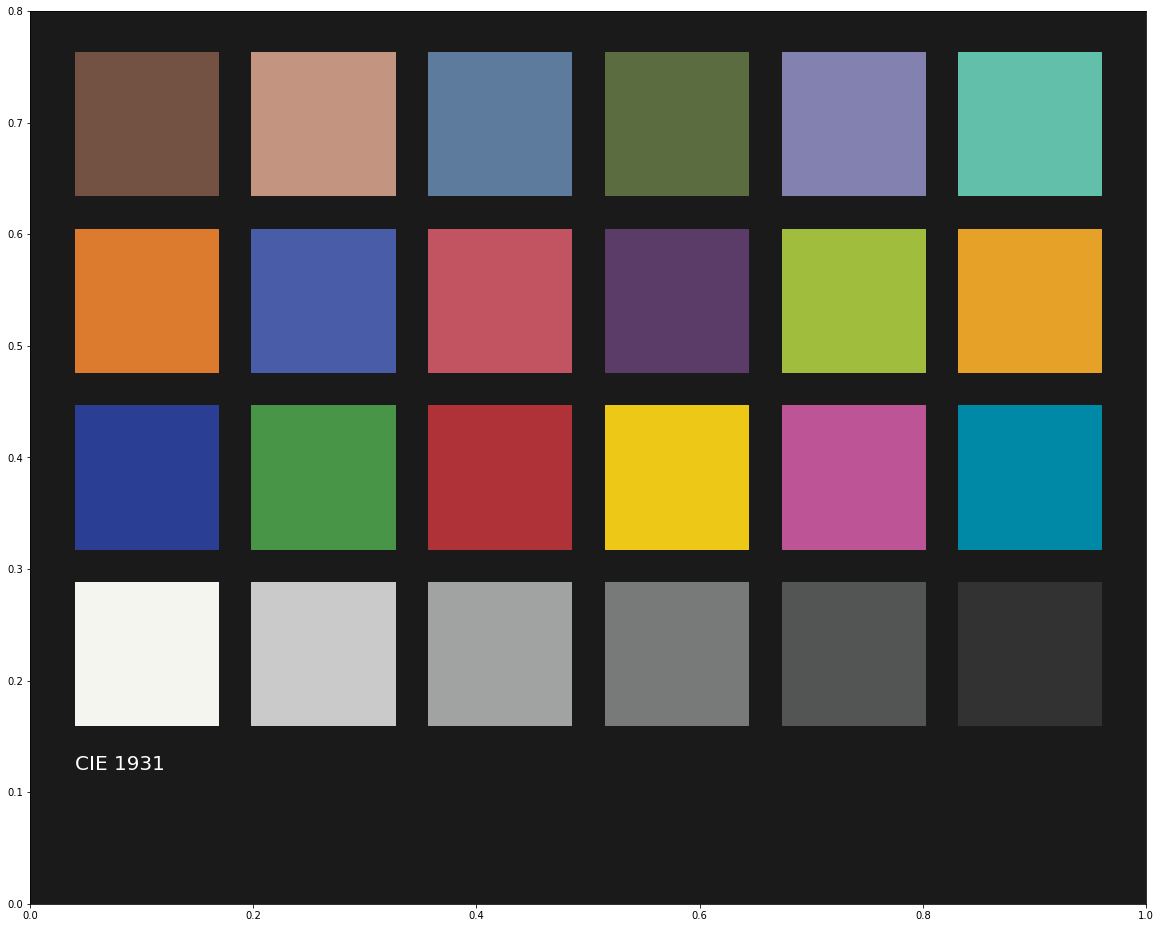

In [ ]:
# Get a copy of BabelColor Average for plotting as CIE 1931
bca = colour.COLOURCHECKERS['BabelColor Average']
colour.COLOURCHECKERS['CIE 1931'] = colour.characterisation.ColourChecker(name='CIE 1931', data = bca.data, illuminant = bca.illuminant)

chart_bca = []
for _, sd in colour.COLOURCHECKERS_SDS['BabelColor Average'].items():
  xyz = colour.sd_to_XYZ(sd, illuminant=sd_d65) / 100
  chart_bca.append(colour.XYZ_to_sRGB(xyz))

chart_bca = np.clip(chart_bca, 0.0, 1.0)
draw_chart([chart_bca], labels=['CIE 1931'])


### 5D dataset definition

Next we'll load the spectral sensitivity curves for the Canon 5D Mark II from the rawtoaces repository.

In [ ]:
cmf_5d = MultiSpectralDistributions(load_ampas_camera_data('canon_eos_5d_mark_ii_380_780_5.json')).align(SpectralShape(360, 830, 1))

# Our two whitepoints in Canon 5D RGB. We'll use these a lot below.
rgb_5d_d65 = sd_to_CameraRGB(colour.sd_ones(), cmf_5d, illuminant = sd_d65) / 100
rgb_5d_3200 = sd_to_CameraRGB(colour.sd_ones(), cmf_5d, illuminant = sd_3200) / 100


### dcraw matrix

First of all, compare CIE 1931 against the 5D matrix extracted from dcraw.

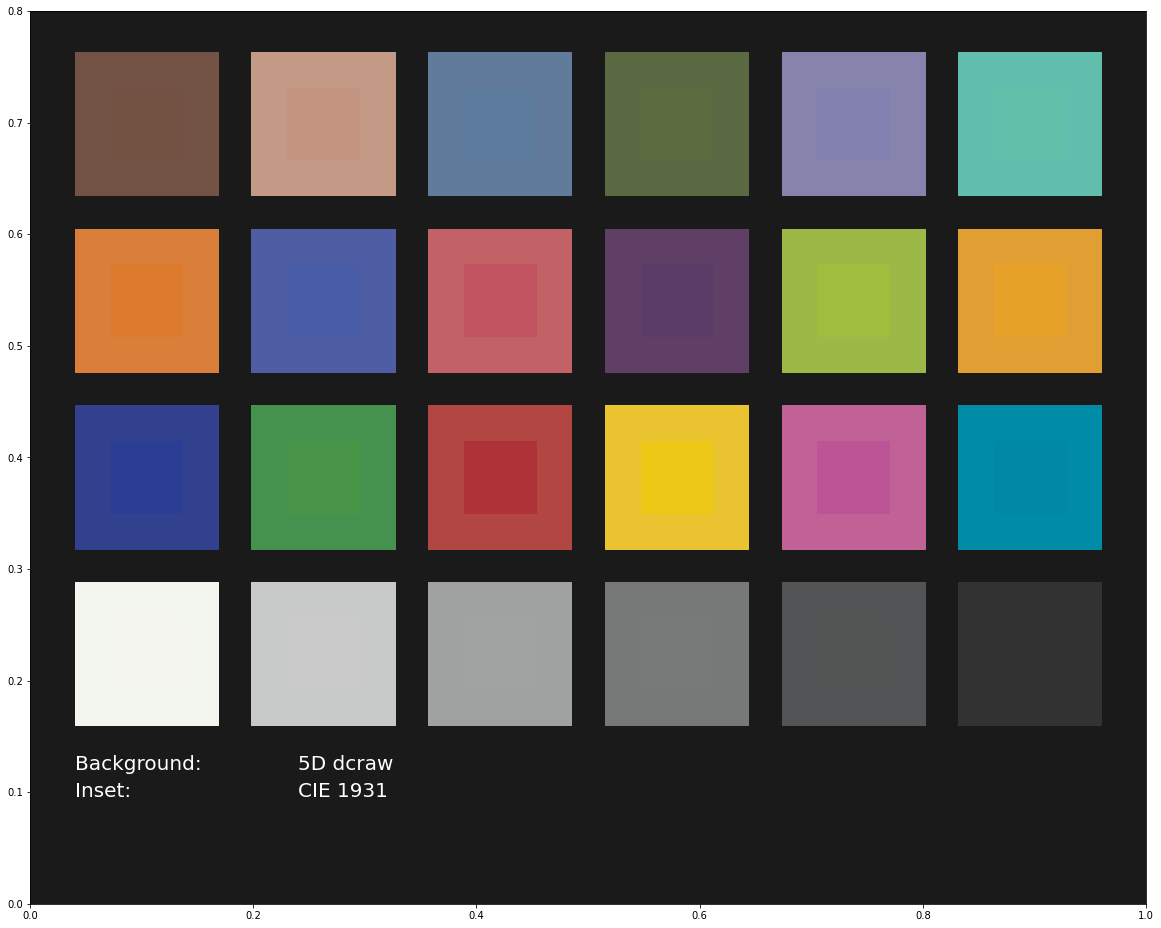

In [ ]:
# This is the matrix extracted from dcraw
rgb_to_xyz_5d_dcraw = [
    [.84582686764400, -0.124656064433,  0.2292851967890], 
    [0.4151331895030,  0.668390503440, -0.0835236929433], 
    [0.0693495723842, -0.222697019629,  1.2421014472500]
]

chart_5d_dcraw = create_chart(cmf = cmf_5d, 
                              src_illuminant_sd = sd_d65, 
                              dst_illuminant_sd = sd_d65, 
                              rgb_to_xyz = rgb_to_xyz_5d_dcraw, 
                              rgb_white = rgb_5d_d65)

draw_chart([chart_5d_dcraw, chart_bca], labels=['5D dcraw', 'CIE 1931'])

### Solve matrix using Macbeth chart

Next we'll try solving our own matrix using linear least squares with the BabelColor Average Macbeth chart as a dataset.

Next compare our matrix solved using the 24-patch macbeth chart against CIE 1931 and the dcraw matrix:


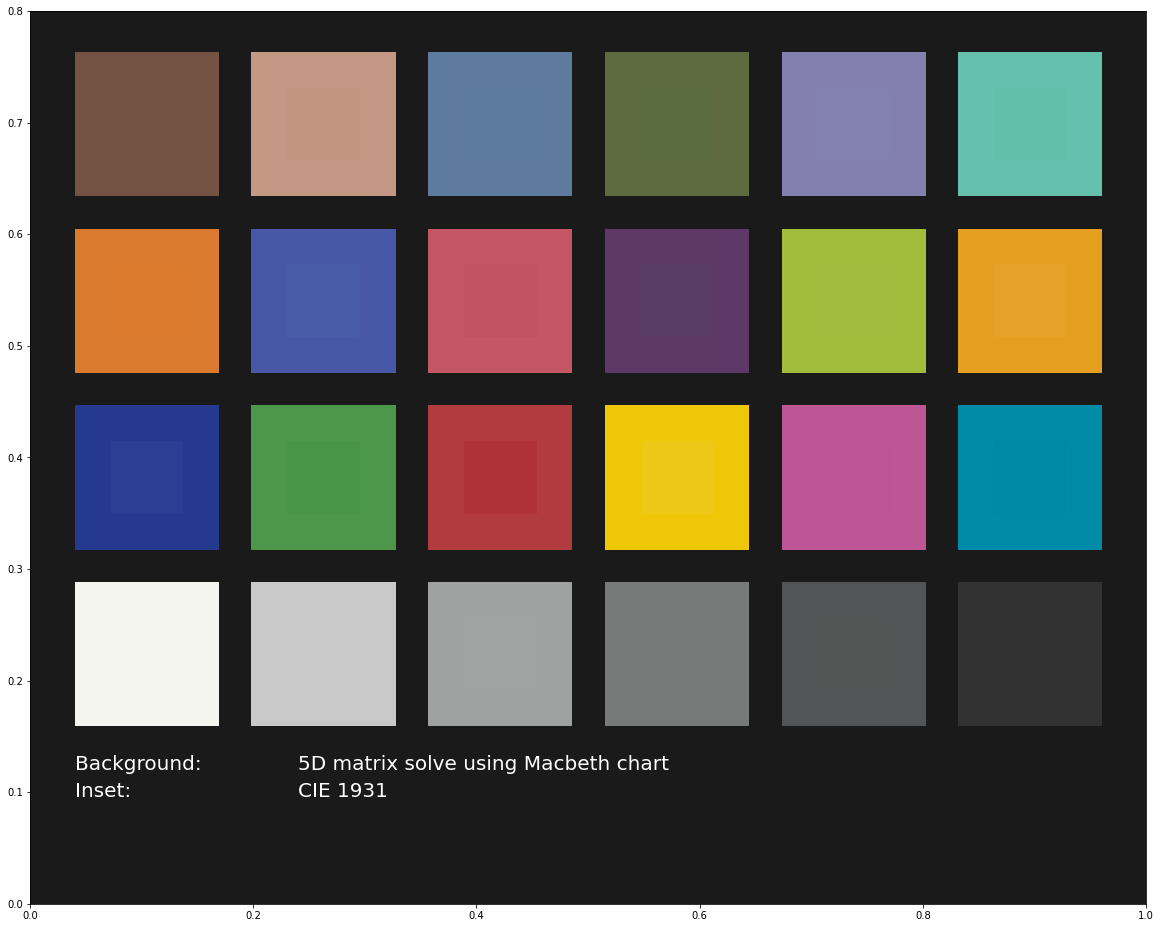

In [ ]:
rgb_to_xyz_5d_macbeth = solve_matrix(cmf_5d, sd_d65, sd_d65, rgb_5d_d65)
chart_5d_macbeth = create_chart(cmf = cmf_5d, 
                                src_illuminant_sd = sd_d65, 
                                dst_illuminant_sd = sd_d65, 
                                rgb_to_xyz = rgb_to_xyz_5d_macbeth, 
                                rgb_white = rgb_5d_d65)

draw_chart([chart_5d_macbeth, chart_bca], labels=['5D matrix solve using Macbeth chart', 'CIE 1931'])


### Solve matrix using rawtoaces training data

Now we'll do the same but using the 190-patch dataset from rawtoaces.

 Next we'll compare using the 24-patch macbeth chart against the 190-patch training dataset from the AMPAS rawtoaces repo: https://github.com/ampas/rawtoaces

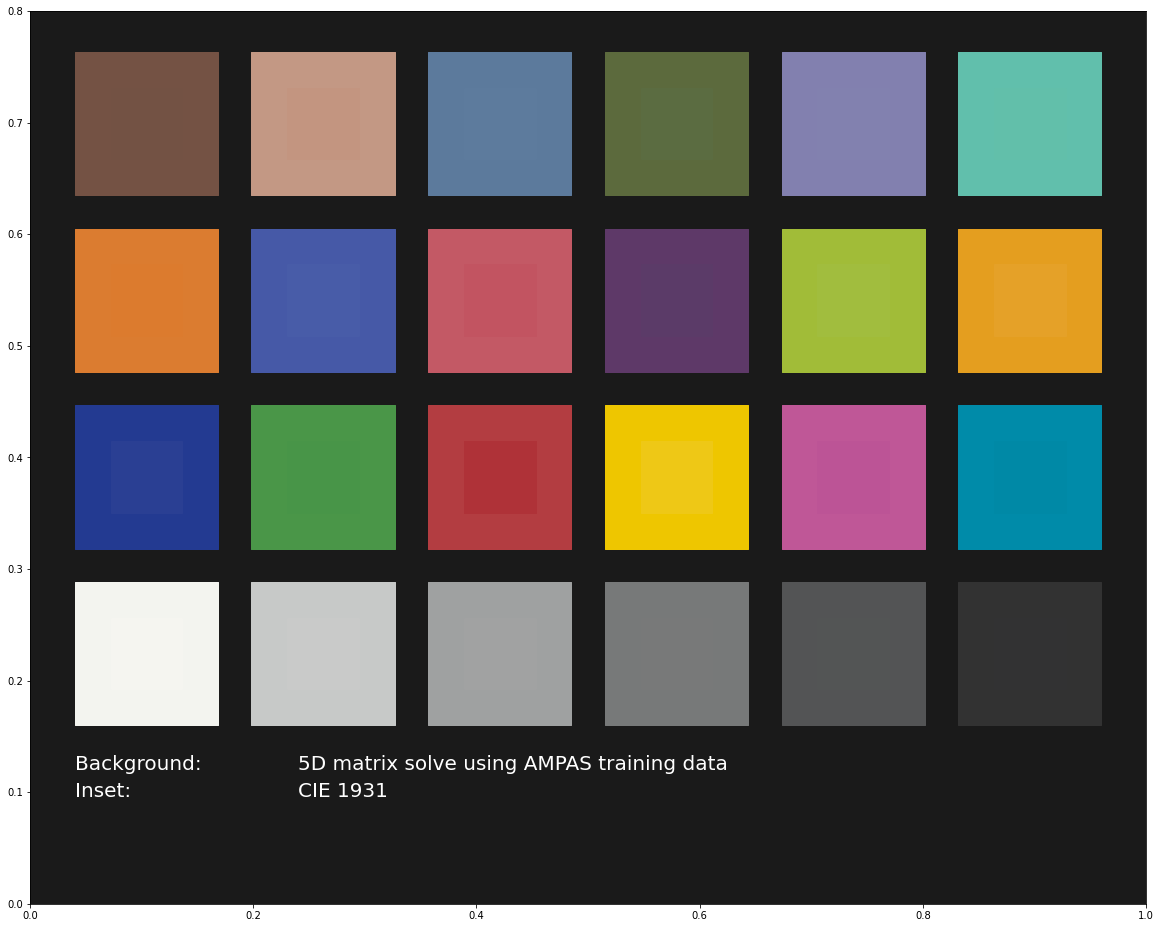

In [ ]:
ampas_training_data = load_ampas_training_data()

rgb_to_xyz_5d_6500 = solve_matrix(cmf_5d, sd_d65, sd_d65, rgb_5d_d65, swatches=ampas_training_data)
chart_5d_ampas_6500 = create_chart(cmf = cmf_5d, 
                                  src_illuminant_sd = sd_d65, 
                                  dst_illuminant_sd = sd_d65, 
                                  rgb_to_xyz = rgb_to_xyz_5d_6500, 
                                  rgb_white = rgb_5d_d65)

draw_chart([chart_5d_ampas_6500, chart_bca], labels=['5D matrix solve using AMPAS training data', 'CIE 1931'])



### Comparison

Finally, let's compare all of these methods against one another. The chart below has the background of each patch divided into sections, each with the result of a different matrix. The inset foreground of each patch is the standard observer conversion.

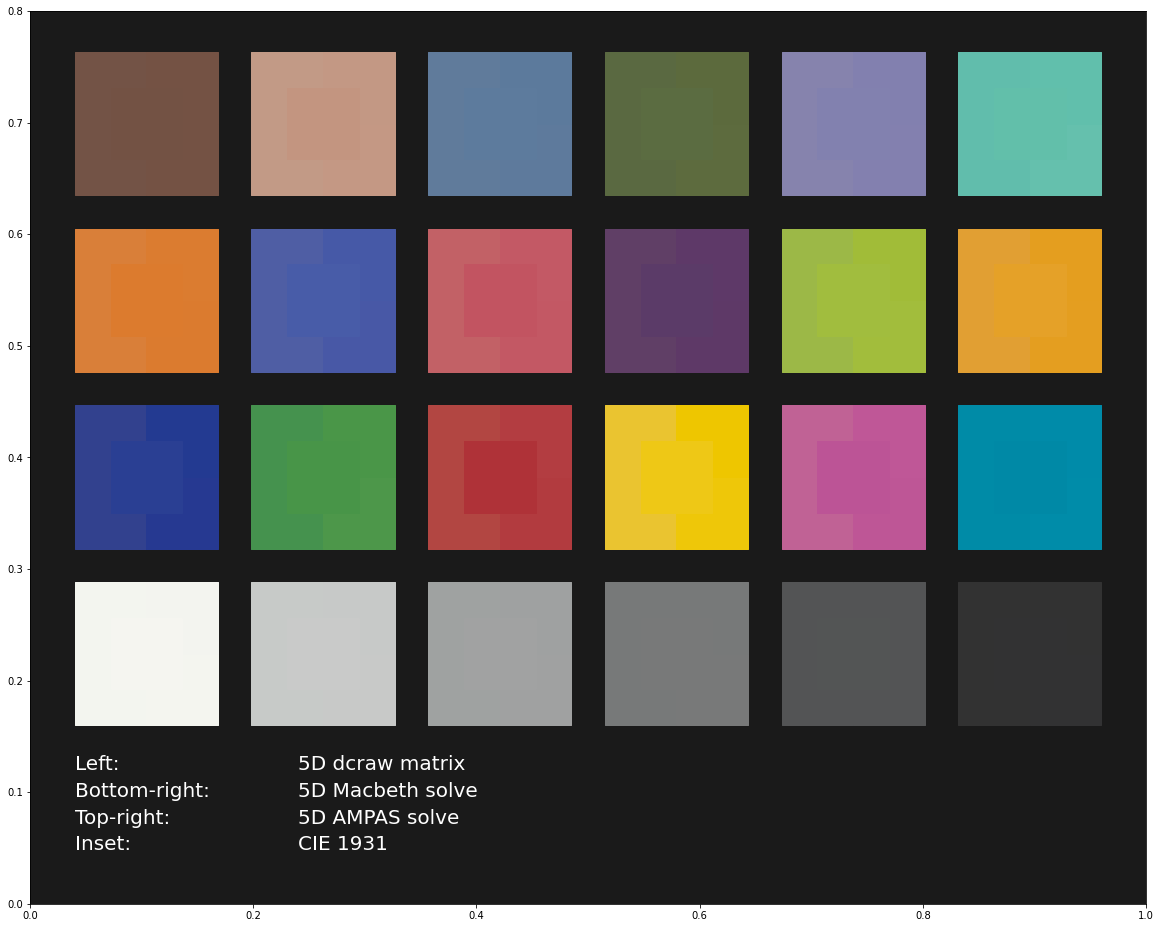

In [ ]:
draw_chart([chart_5d_dcraw, chart_5d_macbeth, chart_5d_ampas_6500, chart_bca], labels=['5D dcraw matrix', '5D Macbeth solve', '5D AMPAS solve', 'CIE 1931'])

## White Balance

Now we'll try rendering the Macbeth chart under 3200K illumination and setting the white point to match, using different methods to perform the balancing. For all of these we'll use the rawtoaces training data when solving the matrices.


### Divide by the RGB white point

 First of all using the divide method, which generates a matrix at 6500K, then just divides by the 3200K whitepoint in CameraRGB space.


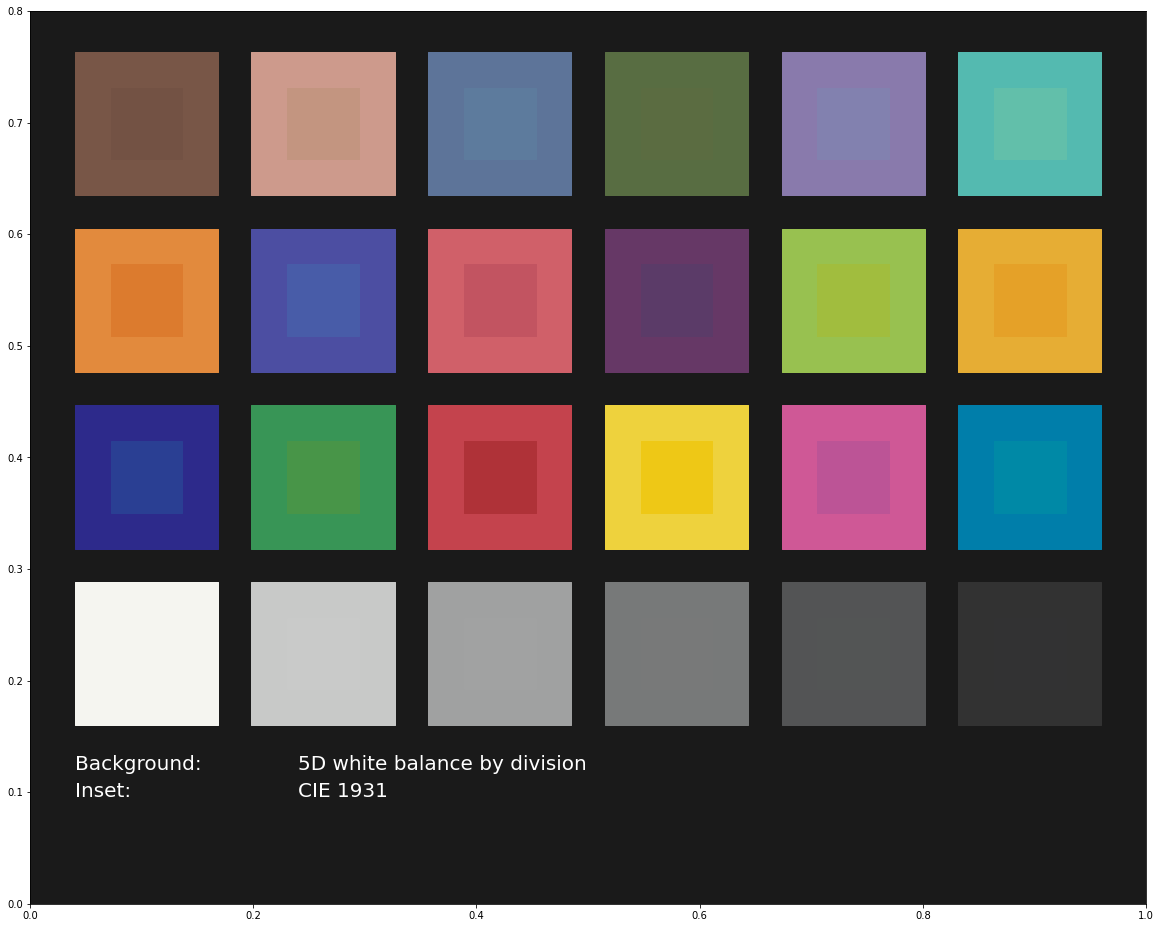

In [ ]:
chart_5d_3200_divide = create_chart(cmf = cmf_5d, 
                                    src_illuminant_sd = sd_3200, 
                                    dst_illuminant_sd = sd_d65, 
                                    rgb_to_xyz = rgb_to_xyz_5d_6500, 
                                    rgb_white = rgb_5d_3200)
draw_chart([chart_5d_3200_divide, chart_bca], labels=['5D white balance by division', 'CIE 1931'])

### Solve a new matrix for the given whitepoint 

Next we'll do the same but solving a new matrix specifically for the 3200K whitepoint.


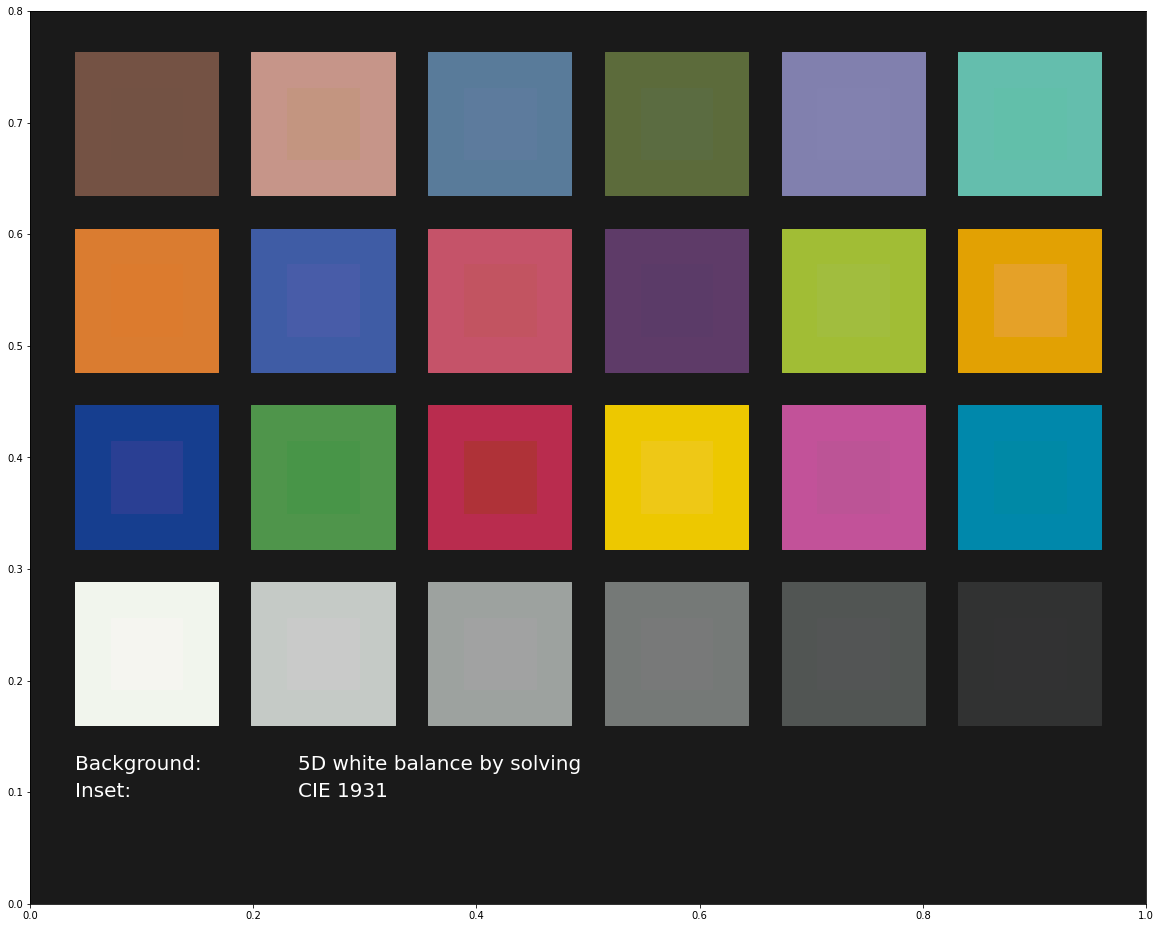

In [ ]:
unit_white = np.array([1,1,1])
rgb_to_xyz_5d_3200 = solve_matrix(cmf_5d, sd_3200, sd_d65, unit_white, swatches=ampas_training_data)
chart_5d_3200_solve = create_chart(cmf = cmf_5d, 
                                    src_illuminant_sd = sd_3200, 
                                    dst_illuminant_sd = sd_d65, 
                                    rgb_to_xyz = rgb_to_xyz_5d_3200, 
                                    rgb_white = unit_white)
draw_chart([chart_5d_3200_solve, chart_bca], labels=['5D white balance by solving', 'CIE 1931'])

### Use the Bradford chromatic adaptation transform

Here we just use the 6500 matrix we solved earlier and use the Bradford CAT to convert our 3200K colours to D65



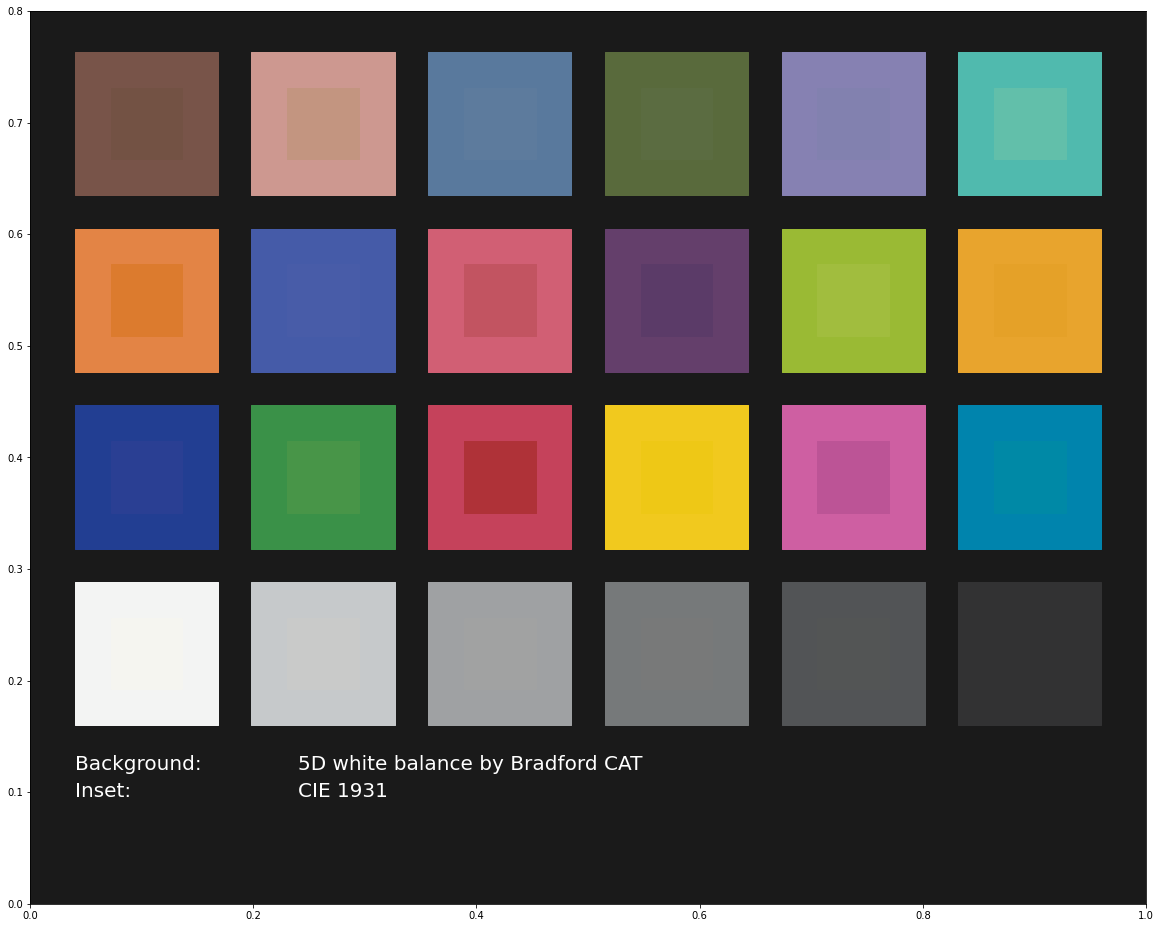

In [ ]:
checkersd = colour.COLOURCHECKERS_SDS['BabelColor Average']
cam_checker_data = {}

xyz_src = colour.sd_to_XYZ(colour.sd_ones(), illuminant=sd_3200)
xyz_dst = colour.sd_to_XYZ(colour.sd_ones(), illuminant=sd_d65)

# We need to account for the difference in luminance between the two white points
# in camera RGB space
cam_xyz_src = sd_to_CameraRGB_to_XYZ(colour.sd_ones(), cmf_5d, sd_3200, rgb_to_xyz_5d_6500, rgb_5d_d65)
cam_xyz_dst = sd_to_CameraRGB_to_XYZ(colour.sd_ones(), cmf_5d, sd_d65, rgb_to_xyz_5d_6500, rgb_5d_d65)
white_scale = cam_xyz_src[1] / cam_xyz_dst[1]

chart_5d_3200_bradford = []
for name, sd in checkersd.items():
  xyz_cam = sd_to_CameraRGB_to_XYZ(sd, cmf_5d, sd_3200, rgb_to_xyz_5d_6500, rgb_5d_d65)
  xyz_cam = colour.adaptation.chromatic_adaptation_VonKries(xyz_cam, xyz_src, xyz_dst, transform='Bradford') / white_scale
  chart_5d_3200_bradford.append(colour.XYZ_to_sRGB(xyz_cam))

draw_chart([chart_5d_3200_bradford, chart_bca], labels=['5D white balance by Bradford CAT', 'CIE 1931'])


### Interpolate a matrix from a sparse set of solves

Finally, if we don't want to solve a matrix every time we could solve it at a few temperatures and interpolate between them. The interpolation method used here is described in the Adobe DNG specification.



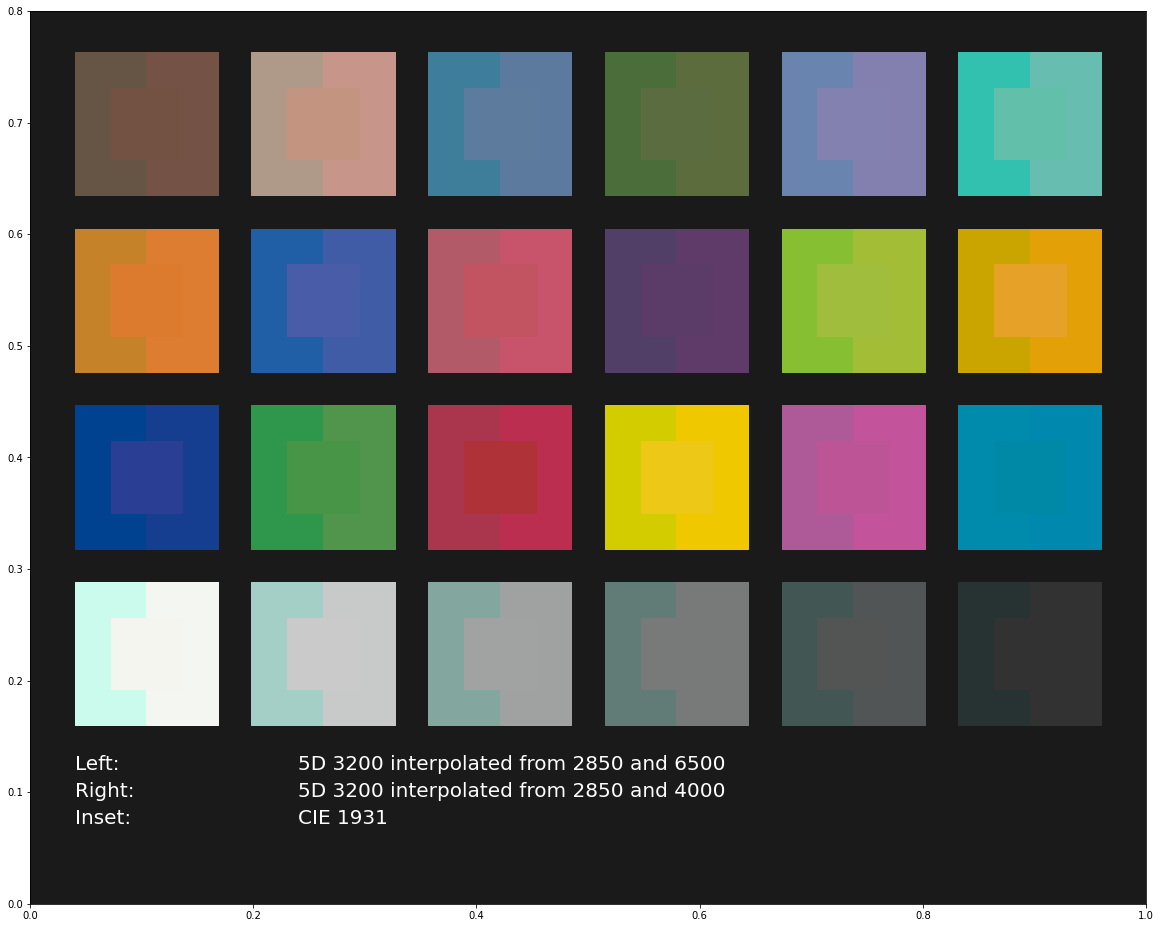

In [ ]:
unit_white = np.array([1,1,1])
sd_A = colour.ILLUMINANTS_SDS['A'] / 100
sd_4000, _ = calculate_whitepoint(4000.0)
rgb_to_xyz_5d_A = solve_matrix(cmf_5d, sd_A, sd_d65, unit_white, swatches=ampas_training_data)
rgb_to_xyz_5d_4000 = solve_matrix(cmf_5d, sd_4000, sd_d65, unit_white, swatches=ampas_training_data)

def interpolate_matrix(mtx_min, mtx_max, k_min, k_max, k):
  m_min = 1.0 / k_min
  m_max = 1.0 / k_max
  m = 1.0 / k
  t = (m - m_min) / (m_max - m_min)
  return mtx_min * (1.0 - t) + mtx_max * t

# First try interpolating between 2850K and 6500K
# This is what the DNG spec suggests (D55 or D65), but it's a bit off
rgb_to_xyz_5d_3200_i = interpolate_matrix(rgb_to_xyz_5d_A, rgb_to_xyz_5d_6500, 2850.0, 6500.0, 3200.0)
chart_5d_3200_interp_6500 = create_chart(cmf = cmf_5d, 
                                        src_illuminant_sd = sd_3200, 
                                        dst_illuminant_sd = sd_d65, 
                                        rgb_to_xyz = rgb_to_xyz_5d_3200_i, 
                                        rgb_white = unit_white)

# Now try interpolating between 2850K and 4000K
# This looks better
rgb_to_xyz_5d_3200_i = interpolate_matrix(rgb_to_xyz_5d_A, rgb_to_xyz_5d_4000, 2850.0, 4000.0, 3200.0)
chart_5d_3200_interp_4000 = create_chart(cmf = cmf_5d, 
                                          src_illuminant_sd = sd_3200, 
                                          dst_illuminant_sd = sd_d65, 
                                          rgb_to_xyz = rgb_to_xyz_5d_3200_i, 
                                          rgb_white = unit_white)

draw_chart([chart_5d_3200_interp_6500, chart_5d_3200_interp_4000, chart_bca], labels=['5D 3200 interpolated from 2850 and 6500', '5D 3200 interpolated from 2850 and 4000', 'CIE 1931'])


### Comparison

Again we compare all methods by dividing the chart patches into sections and showing one set of results per section. The inset foreground is standard observer.

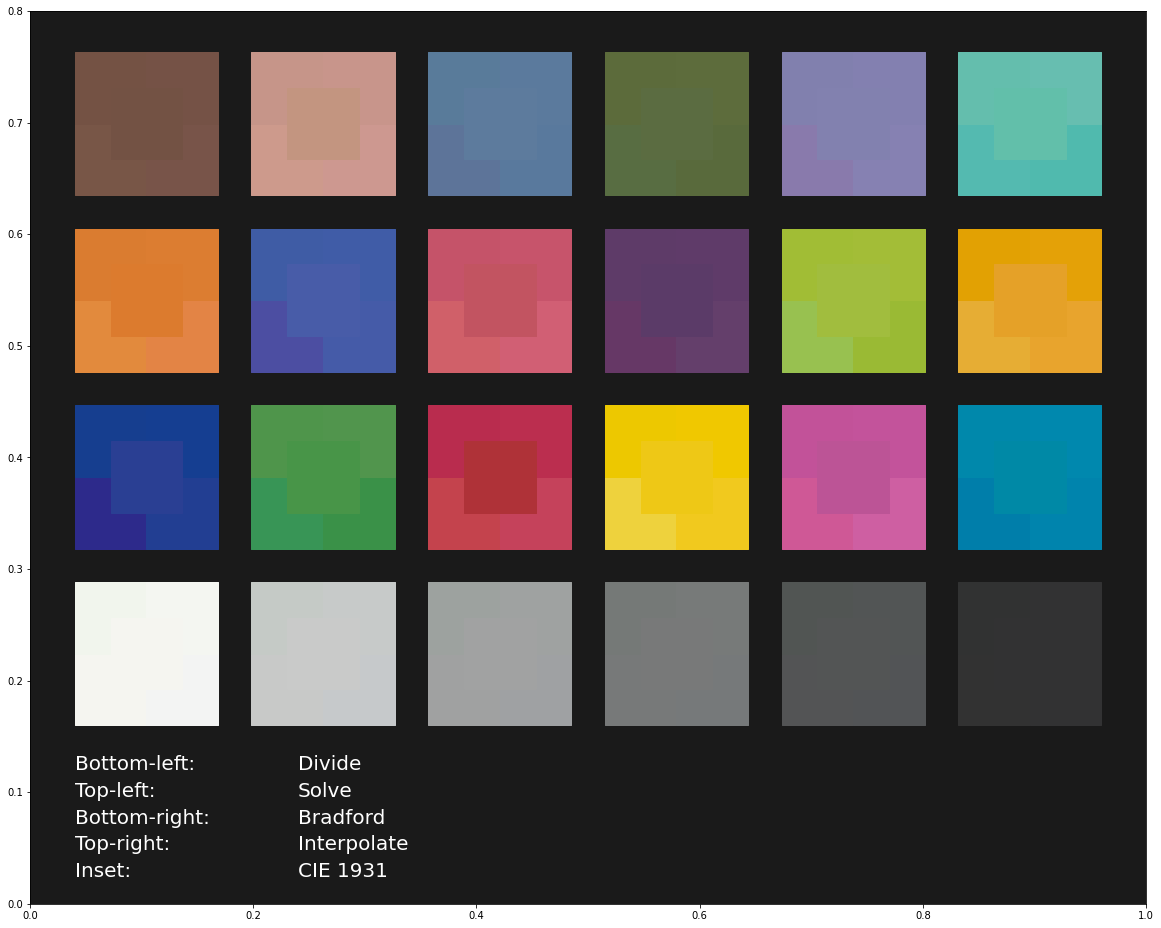

In [ ]:
draw_chart([chart_5d_3200_divide, chart_5d_3200_solve, chart_5d_3200_bradford, chart_5d_3200_interp_4000, chart_bca], labels=['Divide', 'Solve', 'Bradford', 'Interpolate', 'CIE 1931'])